In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.dirname(sys.path[0]))

from tqdm.notebook import tqdm
from segtok import tokenizer

In [ ]:
from data_parsing import load_dataset
data = load_dataset("../yelp_review_training_dataset.jsonl")

In [ ]:
from training_utils import split_train_validation
train_x, valid_x, train_y, valid_y = split_train_validation(data, 0.01)

In [ ]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

In [ ]:
from collections import defaultdict

vocab_frequency = defaultdict(lambda: 0)
for text in tqdm(train_x):
    tokenized = tokenizer.word_tokenizer(text.lower())
    for word in tokenized:
        vocab_frequency[word] += 1

In [ ]:
print(list(vocab_frequency.keys())[:10])

In [ ]:
print(len(vocab_frequency.keys()))
words_to_keep = [key for key in vocab_frequency.keys() if vocab_frequency[key] >= 100]
print(len(words_to_keep))

In [ ]:
word2index = dict()
unk_index = 0
pad_index = 1
next_index = 2
for word in tqdm(vocab_frequency.keys()):
    if word in words_to_keep:
        word2index[word] = next_index
        next_index += 1
    else:
        word2index[word] = unk_index

In [ ]:
print(word2index["hi"])

In [ ]:
vocab_size = max(word2index.values()) + 1 # zero-indexed
print(vocab_size)

In [ ]:
max_len = 0
def numerize_text(text):
    global max_len
    tokenized = tokenizer.word_tokenizer(text.lower())
    numerized = []
    for word in tokenized:
        if word in word2index:
            numerized.append(word2index[word])
        else:
            numerized.append(unk_index)
    max_len = max(max_len, len(numerized))
    return numerized

train_x_numerized = [numerize_text(text) for text in tqdm(train_x)]
valid_x_numerized = [numerize_text(text) for text in tqdm(valid_x)]

In [ ]:
print(max_len)
from training_utils import pad_text
train_x_numerized = [pad_text(text, max_len, pad_index) for text in tqdm(train_x_numerized)]
valid_x_numerized = [pad_text(text, max_len, pad_index) for text in tqdm(valid_x_numerized)]

In [2]:
from utils import memo_load
(train_x_numerized, train_y, valid_x_numerized, valid_y, vocab_size) = memo_load(
    lambda: (train_x_numerized, train_y, valid_x_numerized, valid_y, vocab_size),
    "training_data"
)

In [3]:
import numpy as np

train_x_numerized = np.array(train_x_numerized)[:,:64]
train_y = np.array(train_y)
valid_x_numerized = np.array(valid_x_numerized)[:,:64]
valid_y = np.array(valid_y)

In [4]:
from model import ReviewPredictionModel
import torch as th
import torch.optim as optim

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

model_to_train = None
model_to_train = ReviewPredictionModel(vocab_size, 256)
model_to_train.to(device)
optimizer = optim.Adam(model_to_train.parameters(), lr=1e-4)
batch_size = 128
epochs = 10

cuda


In [5]:
from training_utils import run_training_loop

training_accuracies, validation_accuracies = run_training_loop(
    model_to_train, optimizer, device,
    batch_size, epochs,
    train_x_numerized, train_y, valid_x_numerized, valid_y
)

Epoch: 0 Iteration: 4120 Loss: 0.782 Validation Loss: 0.807 Accuracy: 0.440 Validation Accuracy: 0.418: 100%|██████████| 4127/4127 [01:35<00:00, 43.37it/s]
Epoch: 1 Iteration: 4120 Loss: 0.685 Validation Loss: 0.698 Accuracy: 0.438 Validation Accuracy: 0.462: 100%|██████████| 4127/4127 [01:35<00:00, 43.10it/s]
Epoch: 2 Iteration: 4120 Loss: 0.596 Validation Loss: 0.676 Accuracy: 0.488 Validation Accuracy: 0.482: 100%|██████████| 4127/4127 [01:35<00:00, 43.06it/s]
Epoch: 3 Iteration: 4120 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.510 Validation Accuracy: 0.496: 100%|██████████| 4127/4127 [01:35<00:00, 43.02it/s]
Epoch: 4 Iteration: 4120 Loss: 0.567 Validation Loss: 0.654 Accuracy: 0.510 Validation Accuracy: 0.519: 100%|██████████| 4127/4127 [01:35<00:00, 43.04it/s]
Epoch: 5 Iteration: 4120 Loss: 0.499 Validation Loss: 0.631 Accuracy: 0.513 Validation Accuracy: 0.519: 100%|██████████| 4127/4127 [01:35<00:00, 43.02it/s]
Epoch: 6 Iteration: 4120 Loss: 0.448 Validation Loss: 0.638 Accu

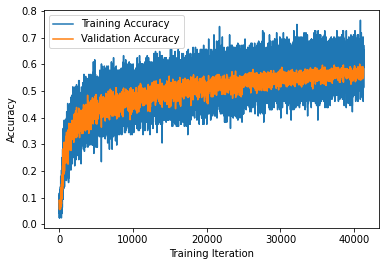

In [7]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 10, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()